# Notebook to test the calibration of the convergence map made from subhalo catalogues

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
from matplotlib import rcParams
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from scipy.special import eval_legendre as leg_pol
%matplotlib inline
# Generic properties from matplotlib
rcParams['font.family'] = 'serif'
rcParams['text.usetex'] = True

In [2]:
# Classes borrowed from the pklens package
class PixelMap(object):
    """
    A general instance of a pixelization of an image.

    Parameters
    ----------
    image_size : float
        The linear size of the image in arcsec. Assumes a square image.
        (default: 4 arcsecs)
    num_pix : int
        The number of pixel along one dimension of the image. The total number
        of pixel for the image will be num_pix**2. (default: 101)

    Attributes
    ----------
    numpix1D : int
        The number of pixel along one dimension of the image.
    image_size : float
        The linear size of the image in arcsec. Assumes a square image.
    xmax : float
        The largest coordinate values of a pixel, assuming the origin to be at
        the center of the image.
    dx : float
        The linear size of a pixel.
    xmap, ymap: ndarray
        The array of coordinates of the pixels. Assumes flat sky.

    Raises
    ------
    TypeError: If number of pixel is not an integer.

    """

    def __init__(self, image_size = 4.0, num_pix=101):

        # Check that the number of pixel is an integer
        if not isinstance(num_pix,int):
            raise TypeError('The number is image pixels must be an integer.')
        # Extract the values
        self.numpix1D = num_pix
        self.image_size = image_size
        self.xmax = image_size/2
        self.dx = image_size/self.numpix1D
        # Central positions of pixels
        self.xmap = np.arange(-self.xmax + self.dx/2,self.xmax, self.dx)
        self.ymap = np.arange(-self.xmax+ self.dx/2,self.xmax, self.dx)
        
class LensCosmo(object):
    """
    The class containing all the cosmological quantities relevant to
    gravitational lensing. It uses Planck15 cosmology.

    Parameters
    ----------
    zlens : float
        The redshift of the lens.
    zsrc : float
        The redshift of the source.
    gravlens_fudge : float, optional
        Factor to account for the numerical difference between the gravlens and
        astropy computation of t_0, the time-delay constant of the lens.
        t_0_gravlens =  gravlens_fudge*t_0_astropy. Set to unity by default.

    Attributes
    ----------
    zlens : float
        The redshift of the lens.
    zsrc : float
        The redshift of the source.
    D_ol : float
        The angular diameter distance between the observer and the lens.
    D_os : float
        The angular diameter distance between the observer and the source.
    D_ls : float
        The angular diameter distance between the lens and the source.
    sigma_crit : float
        The critical density for lensing in units of M_sun/arcsec**2.
    t_0 : float
        The time delay constant in units of days.
    arcsec_2_kpc : float
        The conversion factor between arcsec and kpc [in kpc/arcsec].
    """

    def __init__(self,zlens,zsrc,gravlens_fudge = 1.0):

        #Do some type checking
        if not isinstance(zlens,float):
            raise TypeError('zlens must be a float.')
        if not isinstance(zsrc,float):
            raise TypeError('zsrc must be a float.')
        if zlens > zsrc:
            raise RuntimeError('The source redshift is smaller than the lens redshidt.')

        #If ok, initialize
        self.zlens = zlens
        self.zsrc = zsrc
        self.D_ol = cosmo.angular_diameter_distance(zlens).value
        self.D_os = cosmo.angular_diameter_distance(zsrc).value
        self.D_ls = cosmo.angular_diameter_distance_z1z2(zlens,zsrc).value
        Mpc_2_arcsec = 1.0e-3*cosmo.kpc_proper_per_arcmin(zlens).value/60
        self.sigma_crit = Mpc_2_arcsec**2*((self.D_os/(self.D_ol*self.D_ls))*1.0e6*const.pc.value*
                           const.c.value**2/(4*np.pi*const.G.value*const.M_sun.value))
        self.t_0 = gravlens_fudge*(np.pi/(180*3600))**2*(1 + zlens)*1.0e6*const.pc.value*(self.D_ol*self.D_os/self.D_ls)/const.c.value/86400.0
        self.arcsec_2_kpc = ((np.pi)/(3600*180))*self.D_ol*1000

In [3]:
# define some details from the ETHOS suite of simulations
# N-body dark matter particle mass (in M_sun)
m_res = 2.756e4 
# Minimum number of particle in subhalos
N_min = 50
# cosmo
z_lens1 = 0.5
z_lens2 = 1.0
z_src = 1.5
cosmo_lens1 = LensCosmo(z_lens1,z_src)
cosmo_lens2 = LensCosmo(z_lens2,z_src)

In [6]:
cosmo_lens2.sigma_crit/cosmo_lens1.sigma_crit

3.0620024645083217

In [4]:
# Load the tau, xmax vs rh/rmax relation for tNFW
xmax_tau_vs_rh_rmax = np.genfromtxt('tau_xmax_vs_rhormax.dat')
tau_vs_rh_over_rmax = interp1d(xmax_tau_vs_rh_rmax[:,0],xmax_tau_vs_rh_rmax[:,1],fill_value='extrapolate')
xmax_vs_rh_over_rmax = interp1d(xmax_tau_vs_rh_rmax[:,0],xmax_tau_vs_rh_rmax[:,2],fill_value='extrapolate')

In [5]:
# Load Burkert relation
tau_vs_rhalforburk_dat = np.genfromtxt('tau_vs_rhalf0rburk.dat')
tau_vs_rhalforburk = interp1d(tau_vs_rhalforburk_dat[:,0],tau_vs_rhalforburk_dat[:,1],fill_value='extrapolate')

In [6]:
# Older fitting tNFW relation
tau_vs_xhalf_dat = np.genfromtxt('tau_vs_xhalf.dat')
tau_vs_xhalf = interp1d(tau_vs_xhalf_dat[:,0],tau_vs_xhalf_dat[:,1],fill_value='extrapolate')

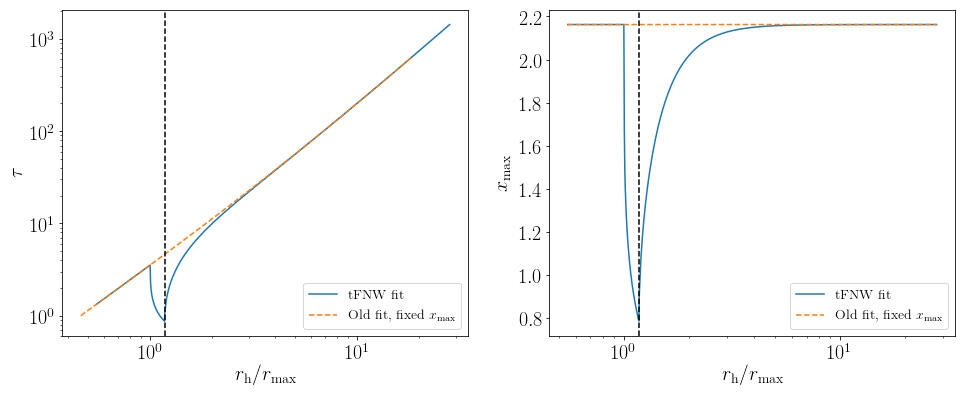

In [7]:
# Plot the calibration formulae
fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.plot(xmax_tau_vs_rh_rmax[:,0],xmax_tau_vs_rh_rmax[:,1],label=r'tFNW fit')
ax1.plot(tau_vs_xhalf_dat[:,0]/2.1626,tau_vs_xhalf_dat[:,1], ls='--', label=r'Old fit, fixed $x_{\rm max}$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$r_{\rm h}/r_{\rm max}$', fontsize=20)
ax1.set_ylabel(r'$\tau$',fontsize=20)
ax1.axvline(1.176,c='k',ls='--')
ax1.legend(fontsize=14)

ax2.plot(xmax_tau_vs_rh_rmax[:,0],xmax_tau_vs_rh_rmax[:,2],label=r'tFNW fit')
ax2.plot(xmax_tau_vs_rh_rmax[:,0],2.1626*np.ones(xmax_tau_vs_rh_rmax[:,0].shape),ls='--',label=r'Old fit, fixed $x_{\rm max}$')
ax2.set_xscale('log')
ax2.set_xlabel(r'$r_{\rm h}/r_{\rm max}$', fontsize=20)
ax2.set_ylabel(r'$x_{\rm max}$',fontsize=20)
ax2.axvline(1.176,c='k',ls='--')
ax2.legend(fontsize=14)

ticklabels = ax1.get_xticklabels()
ticklabels.extend(ax1.get_yticklabels())
ticklabels.extend(ax2.get_xticklabels())
ticklabels.extend(ax2.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
    
#fig1.savefig('Compare_tNFW_fit.pdf',bbox_inches='tight')

In [134]:
def read_catalogue(cat, L_box=600, mlow=0.0, mhigh=1e11, out_vmax=False):
    """
    Function to read subhalo catalogs, and returns subhalo masses, positions, 
    half-mass radii and vmax radii.
    
    Parameters
    ----------
    cat : list
        List of strings containing full path and names of subhalo catalogue files.
    L_box : float
        Size (in kpc) of the box/cube out to which we want to include subhalos
    mlow : float
        Smallest subhalo mass to keep in the analysis (in M_sun)
    mhigh : float
        Largest subhalo mass to keep in the analysis (in M_sun).
    out_vmax : Bool
        Whether to ouput the values of M_max and v_max also.
        
    Returns
    -------
    subh_mass: subhalo masses
    subh_pos: subhalo positions
    rh : halfmass radii
    rvmax: radius at which v_max (max. circular velocity) is achieved
    mmax: Mass within rvmax
    vmax: maximum velocity
    """

    # Iterate over catalogue list entries
    for ic, entry in enumerate(cat):
        # open file
        file = h5py.File(entry,'r')
        # reduced Hubble constant for unit conversion
        h = file['Header'].attrs['HubbleParam']
        # if entry is not empty
        if len(file['Subhalo'].keys()) != 0:
            print('Processing file',entry)
            # extract mass and convert units
            all_masses = file['Subhalo']['SubhaloMass'].value*1e10/h #in M_sun
            # keep only masses above threshold, and below highest mass considered
            mass_cond = np.logical_and(all_masses >= mlow,all_masses < mhigh)
            masses = all_masses[mass_cond]
            # extract positions and convert units
            positions_abs  = file['Subhalo']['SubhaloPos'].value[mass_cond]/h # in kpc, absolute box coordinates
            # Extract half-mass rad and r_max (convert units)
            rhmass = file['Subhalo']['SubhaloHalfmassRad'].value[mass_cond]/h # in kpc
            rvmax = file['Subhalo']['SubhaloVmaxRad'].value[mass_cond]/h # in kpc
            if out_vmax:
                mmax = file['Subhalo']['SubhaloMassInMaxRad'].value[mass_cond]*1e10/h #in M_sun
                vmax = file['Subhalo']['SubhaloVmax'].value[mass_cond] #in km/s
            if ic == 0:
                # Extract parent halo position, assuming it's the Group entry in the first catalogue
                parent_pos = file['Group']['GroupPos'].value/h # in kpc, absolute box coordinates
                # Center on the parent halo
                positions = (positions_abs - parent_pos)
                # Now remove subhalos outside the box
                pos_cond = np.logical_and(positions < L_box/2, positions > -L_box/2).all(axis=1)
                # Save entries into final arrays 
                array_masses = masses[pos_cond]
                array_positions =  positions[pos_cond]
                array_rhmass = rhmass[pos_cond]
                array_rvmax = rvmax[pos_cond]
                if out_vmax:
                    array_mmax = mmax[pos_cond]
                    array_vmax = vmax[pos_cond]
            else:
                # Center on the parent halo
                positions = (positions_abs - parent_pos)
                # Now remove subhalos outside the box
                pos_cond = np.logical_and(positions < L_box/2, positions > -L_box/2).all(axis=1)
                # Save entries into final arrays (removing host)
                array_masses = np.concatenate((array_masses,masses[pos_cond]))
                array_positions = np.concatenate((array_positions,positions[pos_cond]))
                array_rhmass = np.concatenate((array_rhmass,rhmass[pos_cond]))
                array_rvmax = np.concatenate((array_rvmax,rvmax[pos_cond]))
                if out_vmax:
                    array_mmax = np.concatenate((array_mmax,mmax[pos_cond]))
                    array_vmax = np.concatenate((array_vmax,vmax[pos_cond]))
                
        # Close file        
        file.close()
    if out_vmax:        
        return array_masses,array_positions,array_rhmass,array_rvmax,array_mmax,array_vmax
    else:
        return array_masses,array_positions,array_rhmass,array_rvmax

def process_to_Burk(m,rh,rmax):
    """
    Process simulation subhalo properties into Burkert parameters.
    """
    r_b = rmax/3.24463
    tau = tau_vs_rhalforburk(rh/r_b)
    m_b = m*(4*(tau**4 - 1)/(tau**2*(4*tau**2*np.log(tau) - np.pi*(tau - 1)**2)))
  
    return r_b, tau, m_b

def process_to_NFW(m,rh,rmax):
    """
    Process simulation subhalo properties into NFW parameters.
    """
    r_s = rmax/2.1626
    tau = tau_vs_xhalf(rh/r_s)
    m_NFW = m*((tau**2 + 1)**2/(tau**2*((tau**2 - 1)*np.log(tau) + np.pi*tau - (tau**2 + 1))))
  
    return r_s, tau, m_NFW

def process_to_NFW2(m,rh,rmax):
    """
    Process simulation subhalo properties into NFW parameters, with more fancy relation.
    """
    xmax = xmax_vs_rh_over_rmax(rh/rmax)
    r_s = rmax/xmax
    tau = tau_vs_rh_over_rmax(rh/rmax)
    m_NFW = m*((tau**2 + 1)**2/(tau**2*((tau**2 - 1)*np.log(tau) + np.pi*tau - (tau**2 + 1))))
  
    return r_s, tau, m_NFW

def NFW_mass_within_x(x,tau,m_NFW):
    """
    Return the total NFW mass with a radius x = r/r_s
    """
    return m_NFW*tau**2*(-2*x*(1 + tau**2) + 4*(1 + x)*tau*np.arctan(x/tau) + \
           2*(1 + x)*(-1 + tau**2)*np.log((1 + x)*tau) - (1 + x)*(-1 + tau**2)*np.log(x**2 + tau**2))/(2*(1 + x)*(1 + tau**2)**2)

def Burk_mass_within_x(x,tau,m_b):
    """
    Return the total Burkert mass within a radius x = r/r_b
    """
    return m_b*(tau**2*(-2*(1+tau**2)*np.arctan(x)+4*tau*np.arctan(x/tau)-2*np.log(1+x)+(1+tau**2)*np.log(1+x**2)+2*tau**2*np.log(((1+x)*tau**2)/(x**2+tau**2)))/(4*(-1+tau**4)))

def tidal_model(m,r3D):
    """Tidal model from Binney and Tremaine"""
    rt = (m/1e6)**(1/3)*(r3D/100)**(2/3)
    return rt

def process_to_NFW_approx(m,pos,rmax):
    """
    Process simulation subhalo properties into NFW parameters.
    """
    r_s = rmax/2.1626
    r = np.sqrt(np.sum(pos**2,axis=1))
    r_t = tidal_model(m,r)
    tau = r_t/r_s
    m_NFW = m*((tau**2 + 1)**2/(tau**2*((tau**2 - 1)*np.log(tau) + np.pi*tau - (tau**2 + 1))))
  
    return r_s, tau, m_NFW
    
    
def extract_pksub(kappa_map, image_size, num_kmodes, kmin=None, kmax=None, log_bin=True):
    """
    Function to measure the power spectrum from a kappa map, in a certain
    number of wavenumber bins. Also return sample variance error bars.

    Returns
    -------
    kbin_center, Psub, errPsub

    """

    #extract image pixel size
    numx = kappa_map.shape[0]
    numy = kappa_map.shape[1]

    #pixel area
    pix_area = image_size**2/(numx*numy)

    #perform Fourier transform of kappa map
    FTkappa = pix_area*np.fft.fft2(np.fft.ifftshift(kappa_map))

    #Compute 2D power spectrum. Note the normalization.
    Psub2D = np.fft.fftshift(FTkappa*FTkappa.conj())/image_size**2

    #Define k-mode grid
    fftindx = 2.0*np.pi*np.fft.fftshift(np.fft.fftfreq(numx,d=image_size/numx))
    fftindy = 2.0*np.pi*np.fft.fftshift(np.fft.fftfreq(numy,d=image_size/numy))
    meshkx,meshky = np.meshgrid(fftindx,fftindy)
    kvalgrid = np.sqrt(meshkx**2 + meshky**2)
    
    # Whether to use log or linear bins
    if log_bin:
        if kmin != None :
            logkmin = np.log10(kmin)
        else:
            logkmin = np.log10(2*np.pi/image_size)
        if kmax != None:
            logkmax = np.log10(kmax)
        else:
            logkmax = np.log10(np.max(meshkx))
        dlogk = (logkmax - logkmin)/num_kmodes
        kbin = (10.0**np.arange(logkmin,logkmax+dlogk,dlogk))
        kbin_center = (10.0**np.arange(logkmin + dlogk/2,0.9999*logkmax,dlogk))
    else:    
        kmin = 2*np.pi/image_size
        kmax = np.max(meshkx)
        dk = (kmax - kmin)/num_kmodes
        kbin = np.arange(kmin,kmax+dk,dk)
        kbin_center = np.arange(kmin + dk/2,0.9999*kmax,dk)

    #Do circular average
    Psub = np.zeros(kbin_center.shape)
    errPsub = np.zeros(kbin_center.shape)
    for i in range(kbin_center.shape[0]):
        kvallow = kbin[i]
        kvalhigh = kbin[i+1]
        mask = np.zeros((numx,numy))
        mask[np.logical_and(kvalgrid >= kvallow , kvalgrid < kvalhigh)] = 1.0
        Psub1k = Psub2D.real*mask
        NonzeroPsub = np.extract(Psub1k != 0.0,Psub1k)
        Psub[i] = np.mean(NonzeroPsub)
        errPsub[i] = np.sqrt(2)*(Psub[i])/np.sqrt(NonzeroPsub.size)

    return kbin_center,Psub,errPsub

In [9]:
# catalogue file list
Num_files = 16
cat_dir_ethos = '../ETHOS_4_cat/'
cat_dir_cdm = '../CDM/'
cat_root = 'fof_subhalo_tab_'
snapshot1 = '078'
snapshot2 = '095'
snapshot3 = '127'
cat_list_cdm1 = [cat_dir_cdm + cat_root + snapshot1 + '.' + str(i) + '.hdf5' for i in range(Num_files)]
cat_list_cdm2 = [cat_dir_cdm + cat_root + snapshot2 + '.' + str(i) + '.hdf5' for i in range(Num_files)]
cat_list_cdm3 = [cat_dir_cdm + cat_root + snapshot3 + '.' + str(i) + '.hdf5' for i in range(Num_files)]
cat_list_ethos1 = [cat_dir_ethos + cat_root + snapshot1 + '.' + str(i) + '.hdf5' for i in range(Num_files)]
cat_list_ethos2 = [cat_dir_ethos + cat_root + snapshot2 + '.' + str(i) + '.hdf5' for i in range(Num_files)]
cat_list_ethos3 = [cat_dir_ethos + cat_root + snapshot3 + '.' + str(i) + '.hdf5' for i in range(Num_files)]

In [10]:
# Load properties at z=1
m_CDM1, pos_CDM1, rh_CDM1, rmax_CDM1 = read_catalogue(cat_list_cdm1,L_box=600,mlow=m_res*N_min, mhigh=1e8, out_vmax=False)
m_et1, pos_et1, rh_et1, rmax_et1 = read_catalogue(cat_list_ethos1,L_box=600,mlow=m_res*N_min, mhigh=1e8, out_vmax=False)

Processing file ../CDM/fof_subhalo_tab_078.0.hdf5
Processing file ../CDM/fof_subhalo_tab_078.1.hdf5
Processing file ../CDM/fof_subhalo_tab_078.2.hdf5
Processing file ../CDM/fof_subhalo_tab_078.3.hdf5
Processing file ../CDM/fof_subhalo_tab_078.4.hdf5
Processing file ../CDM/fof_subhalo_tab_078.5.hdf5
Processing file ../CDM/fof_subhalo_tab_078.6.hdf5
Processing file ../CDM/fof_subhalo_tab_078.7.hdf5
Processing file ../CDM/fof_subhalo_tab_078.8.hdf5
Processing file ../CDM/fof_subhalo_tab_078.9.hdf5
Processing file ../CDM/fof_subhalo_tab_078.10.hdf5
Processing file ../CDM/fof_subhalo_tab_078.11.hdf5
Processing file ../CDM/fof_subhalo_tab_078.12.hdf5
Processing file ../CDM/fof_subhalo_tab_078.13.hdf5
Processing file ../CDM/fof_subhalo_tab_078.14.hdf5
Processing file ../CDM/fof_subhalo_tab_078.15.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_078.0.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_078.1.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_078.2.hdf5
Processing file ../E

In [282]:
# Load ETHOS-4 properties
m_et, pos_et, rh_et, rmax_et = read_catalogue(cat_list_ethos,L_box=600,mlow=m_res*37, mhigh=1e10, out_vmax=False)

Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.0.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.2.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.3.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.4.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.5.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.6.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.7.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.8.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.9.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.10.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.11.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.12.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.13.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.14.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.15.hdf5


In [283]:
# Compute NFW properties
r_s, tau, m_NFW = process_to_NFW(m_CDM, rh_CDM, rmax_CDM)

In [284]:
# Compute Burkert properties 
r_b, taub, m_b = process_to_Burk(m_et, rh_et, rmax_et)

# Make some diagnostic plots

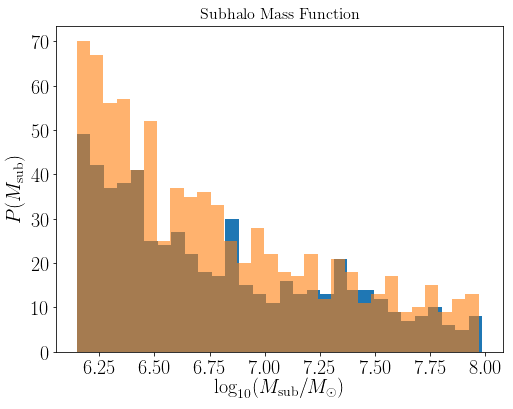

In [202]:
# Plot subhalo mass function
fig5, ax5 = plt.subplots(figsize=(8,6))
Pm, be, cc = ax5.hist(np.log10(m_et05),bins=30,density=False,log=False)
Pm2, be2, cc2 = ax5.hist(np.log10(m_et0),bins=30,density=False,log=False,alpha=0.6)

# Plot some mass function power law
#ax5.plot(be,0.085*(10**be/1e8)**(-0.9))

# Make the plot pretty
ax5.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$', fontsize=20)
ax5.set_ylabel(r'$P(M_{\rm sub})$', fontsize=20)
ax5.set_title(r'Subhalo Mass Function',fontsize=16)
ticklabels = ax5.get_xticklabels()
ticklabels.extend(ax5.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)

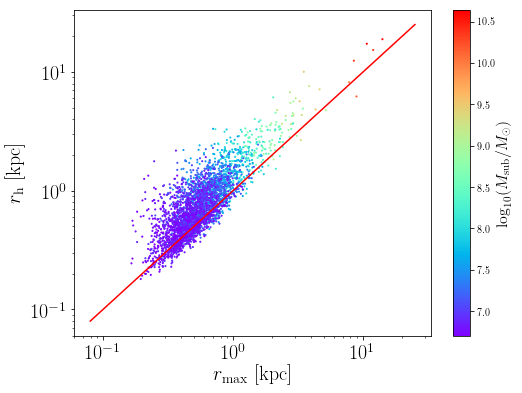

In [191]:
# r_t vs r_s
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.scatter(rmax[m>5e6],rh[m>5e6],c=np.log10(m[m>5e6]),s=1.2,cmap='rainbow')
rm = np.logspace(-1.1,1.4)
ax.plot(rm,rm,c='r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_{\rm max}$ [kpc]',fontsize=20)
ax.set_ylabel(r'$r_{\rm h}$ [kpc]',fontsize=20)
ticklabels = ax.get_xticklabels()
ticklabels.extend(ax.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
col = fig.colorbar(im)
col.set_label(r'$\log_{10}(M_{\rm sub}/M_\odot)$',fontsize=16)

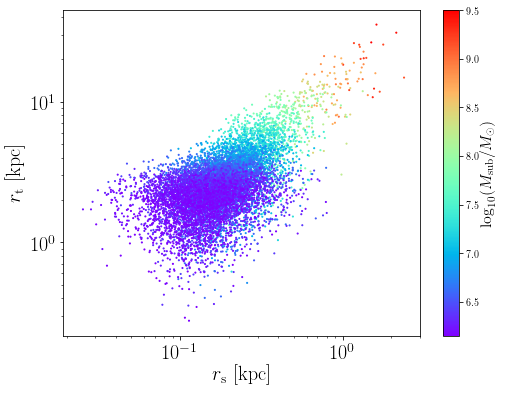

In [73]:
# r_t vs r_s
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.scatter(r_s1,tau1*r_s1,c=np.log10(m),s=1.2,cmap='rainbow')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_{\rm s}$ [kpc]',fontsize=20)
ax.set_ylabel(r'$r_{\rm t}$ [kpc]',fontsize=20)
ticklabels = ax.get_xticklabels()
ticklabels.extend(ax.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
col = fig.colorbar(im)
col.set_label(r'$\log_{10}(M_{\rm sub}/M_\odot)$',fontsize=16)

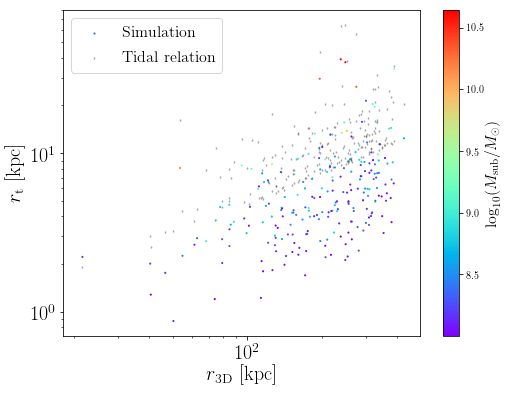

In [254]:
# r_t vs r_3D
r3D = np.sqrt(np.sum(pos_CDM**2,axis=1))
cond = m_CDM > 1e8
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.scatter(r3D[cond],(tau*r_s)[cond],c=np.log10(m_CDM[cond]),s=1.2,cmap='rainbow',label=r'Simulation')
ax.scatter(r3D[cond],tidal_model(m_CDM,r3D)[cond],c='k',marker='d',s=2, alpha=0.2, label=r'Tidal relation')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_{\rm 3D}$ [kpc]',fontsize=20)
ax.set_ylabel(r'$r_{\rm t}$  [kpc]',fontsize=20)
ticklabels = ax.get_xticklabels()
ticklabels.extend(ax.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
col = fig.colorbar(im)
col.set_label(r'$\log_{10}(M_{\rm sub}/M_\odot)$',fontsize=16)
ax.legend(fontsize=16)
#fig.savefig('tidal_truncation.pdf',bbox_inches='tight')

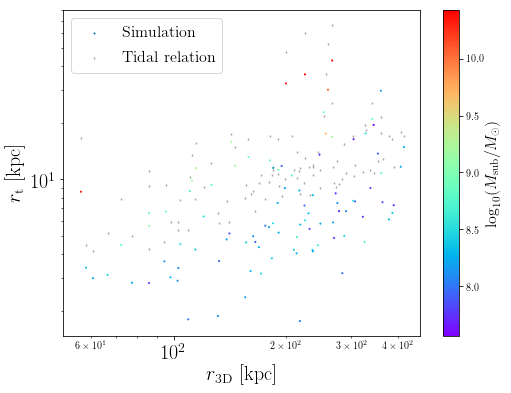

In [255]:
# r_t vs r_3D
r3D = np.sqrt(np.sum(pos_et**2,axis=1))
cond = m_et > 1e8
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.scatter(r3D[cond],(taub*r_b)[cond],c=np.log10(m_b[cond]),s=1.2,cmap='rainbow',label=r'Simulation')
ax.scatter(r3D[cond],tidal_model(m_et,r3D)[cond],c='k',marker='d',s=2, alpha=0.2, label=r'Tidal relation')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_{\rm 3D}$ [kpc]',fontsize=20)
ax.set_ylabel(r'$r_{\rm t}$  [kpc]',fontsize=20)
ticklabels = ax.get_xticklabels()
ticklabels.extend(ax.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
col = fig.colorbar(im)
col.set_label(r'$\log_{10}(M_{\rm sub}/M_\odot)$',fontsize=16)
ax.legend(fontsize=16)
#fig.savefig('tidal_truncation.pdf',bbox_inches='tight')

### So, tidal relation is fine for subhalos that aren't too truncated, but doesn't capture a large population of disrupted small halos

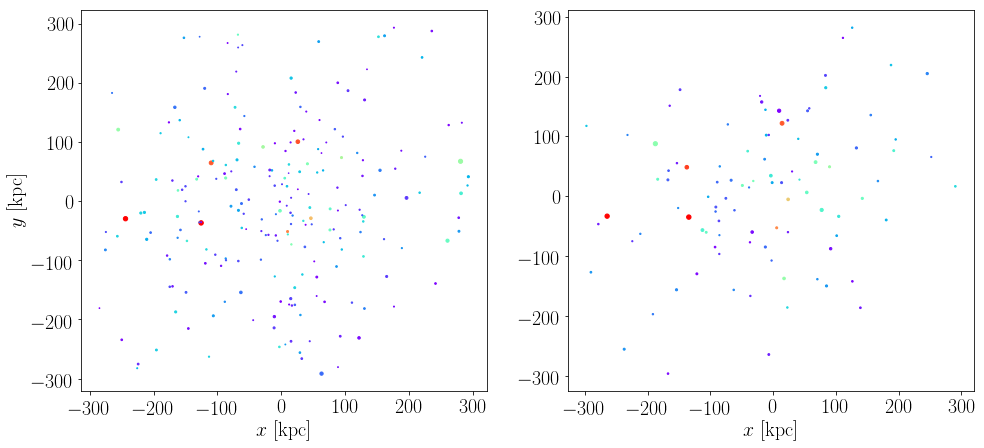

In [259]:
# x vs y vs m
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 7))
cond1 = m_CDM > 1e8
im = ax1.scatter(pos_CDM[:,0][cond1],pos_CDM[:,1][cond1],c=np.log10(m_CDM[cond1]),s=0.5*tau*r_s,cmap='rainbow')
ax1.set_xlabel(r'$x$ [kpc]',fontsize=20)
ax1.set_ylabel(r'$y$ [kpc]',fontsize=20)
cond2 = m_et > 1e8
im2 = ax2.scatter(pos_et[:,0][cond2],pos_et[:,1][cond2],c=np.log10(m_et[cond2]),s=0.5*tau*r_s,cmap='rainbow')
ax2.set_xlabel(r'$x$ [kpc]',fontsize=20)


ticklabels = ax1.get_xticklabels()
ticklabels.extend(ax1.get_yticklabels())
ticklabels.extend(ax2.get_xticklabels())
ticklabels.extend(ax2.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
#col = fig.colorbar(im2)
#col.set_label(r'$\log_{10}(M_{\rm sub}/M_\odot)$',fontsize=16)

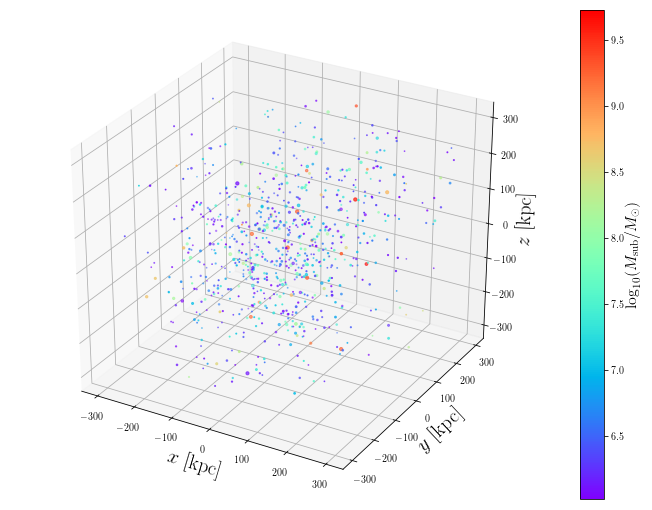

In [85]:
# 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

im = ax.scatter(pos[:,0],pos[:,1],pos[:,2],c=np.log10(m),s=0.6*tau*r_s,cmap='rainbow')

ax.set_xlabel(r'$x$ [kpc]',fontsize=20)
ax.set_ylabel(r'$y$ [kpc]',fontsize=20)
ax.set_zlabel(r'$z$ [kpc]',fontsize=20)
col = fig.colorbar(im)
col.set_label(r'$\log_{10}(M_{\rm sub}/M_\odot)$',fontsize=16)

In [14]:
# Define projected tNFW profile
def FNFW(x):
    up = x>1
    down = np.logical_not(up)
    lowx = np.arccosh(1/x[down])/np.sqrt(1 - x[down]**2)
    highx = np.arccos(1/x[up])/np.sqrt(x[up]**2 - 1)
    ans = np.zeros(x.shape)
    ans[down] = lowx
    ans[up] = highx
    return ans

def conv_tnfw(x,y,xsub,ysub,mnfw,rs,tau):
    """
    Convergence of tNFW, without the sigma_crit factor
    """
    z = np.sqrt((x-xsub)**2 + (y-ysub)**2)/rs
    Lz = np.log(z/(tau+np.sqrt(tau**2+z**2)))
    Fz = FNFW(z)
    sig = (mnfw/(rs**2))*(tau**2/(2*np.pi*(tau**2 + 1)**2))*(((tau**2 + 1)/(z**2 - 1))*(1 - Fz) + 2*Fz - np.pi/np.sqrt(tau**2 + z**2) + ((tau**2 - 1)/(tau*np.sqrt(tau**2 + z**2)))*Lz)
    return sig

In [15]:
# Define projected Burkert profile

def term2(x,p,tau):
    down = x < p
    up = np.logical_not(down)
    lowx = np.sqrt(1/(x[up]**2-p**2))/(p*(p**2+tau**2))
    highx = 0
    ans = np.zeros(x.shape)
    ans[up] = lowx
    ans[down] = highx
    return ans

def term4(x,p,tau):
    down = x < p
    up = np.logical_not(down)
    lowx = 2*np.arctan(p/np.sqrt(x[up]**2-p**2)) / ((p**3+p*tau**2)*np.sqrt(x[up]**2 - p**2))
    highx = np.real(2*np.arctan(p/(1j*np.sqrt(p**2-x[down]**2))) / ((p**3+p*tau**2)*1j*np.sqrt(p**2-x[down]**2)))
    ans = np.zeros(x.shape)
    ans[up] = lowx
    ans[down] = highx
    return ans

def conv_tburk_2d(x,y,xsub,ysub,m_b,r_b,taub):
    """
    Convergence of tBurk, without the sigma_crit factor
    """
    p = 0.66651
    t = p*taub
    rs = r_b/p
    z = np.sqrt((x-xsub)**2+(y-ysub)**2)/rs
    term_1 = (2*p*np.sqrt(1/(t**2+z**2)))/(p**4 - t**4) 
    term_2 = term2(z,p,t)
    term_3 = np.sqrt(1/(z**2+p**2))/(p**3-p*t**2)
    term_4 = term4(z,p,t)
    term_5 = 2*np.arctanh(p/np.sqrt(z**2+p**2)) / ((p**3-p*t**2)*np.sqrt(z**2+p**2))
    term_6 = 4*t*np.arctanh(t/np.sqrt(z**2+t**2)) / ((p**4-t**4)*np.sqrt(z**2+t**2))
    sig = (m_b/(8*np.pi*rs**2))*t**2 * (np.pi*(term_1 - term_2 - term_3) + term_4 - term_5 + term_6)
    return sig

In [163]:
def make_projected_maps(pos, m_NFW, r_s, tau, cosmo_lens, pixmap, num_maps=100, keep_fac=2, seed=None):
    """
    Routine to make projected convergence maps
    """
    #Sigma_crit
    sigcrit = cosmo_lens.sigma_crit/(cosmo_lens.arcsec_2_kpc)**2
    
    # Number of bins for nsub map
    bin_for_2D = 20
    
    # Generate meshgrid on which to evaluate projection
    X, Y = np.meshgrid(pixmap.xmap, pixmap.ymap)
    
    # Generate a random projection angle
    np.random.seed(seed)
    theta = np.random.uniform(0, np.pi, size=num_maps)
    phi = np.random.uniform(0, 2*np.pi, size=num_maps)
    
    # 2D unit vectors
    theta_hat = np.array([np.cos(theta)*np.cos(phi),np.cos(theta)*np.sin(phi),-np.sin(theta)]).T
    phi_hat = np.array([-np.sin(phi),np.cos(phi),np.zeros(num_maps)]).T
    
    kap = np.zeros((num_maps,pixmap.numpix1D,pixmap.numpix1D))
    nsub2D = np.zeros((num_maps,bin_for_2D,bin_for_2D))
    for imap in range(num_maps):
        print('Processing Map',imap+1,'out of',num_maps)
        # Compute projected positions of subhalos
        sub_pos = np.vstack((np.tensordot(pos,theta_hat[imap],axes=1),
                             np.tensordot(pos,phi_hat[imap],axes=1))).T
        # For speed, remove subhalos that get projected far from the region of interest
        pos_cond = np.logical_and(sub_pos < keep_fac*pixmap.xmax, sub_pos > -keep_fac*pixmap.xmax).all(axis=1)
        this_pos = sub_pos[pos_cond]
        this_mass = m_NFW[pos_cond]
        this_r_s = r_s[pos_cond]
        this_tau = tau[pos_cond]
        
        # Number of subhalos left
        num_subhalos = this_tau.size
        
        # Compute convergence (would like to speed up this step!)
        kap[imap] = np.sum([conv_tnfw(X,Y,this_pos[j,0],this_pos[j,1],this_mass[j],
                                      this_r_s[j],this_tau[j]) for j in range(num_subhalos)],axis=0)
        
        # Pixel area
        box_size = pixmap.image_size
        pix_area = box_size**2/bin_for_2D**2
        

        # Bin the positions
        H, xedges, yedges = np.histogram2d(this_pos[:,0], this_pos[:,1], bins=bin_for_2D, 
                                   range = [[-box_size/2, box_size/2], [-box_size/2, box_size/2]])

        # Compute nsub2D
        nsub2D[imap] = H.T/pix_area
        
    return kap/sigcrit,nsub2D

def make_projected_maps_burk(pos, m_b, r_b, taub, cosmo_lens, pixmap, num_maps=100, keep_fac=2, seed=None):
    """
    Routine to make projected convergence maps
    """
    #Sigma_crit
    sigcrit = cosmo_lens.sigma_crit/(cosmo_lens.arcsec_2_kpc)**2
    
    # Number of bins for nsub map
    bin_for_2D = 20
    
    # Generate meshgrid on which to evaluate projection
    X, Y = np.meshgrid(pixmap.xmap, pixmap.ymap)
    
    # Generate a random projection angle
    np.random.seed(seed)
    theta = np.random.uniform(0, np.pi, size=num_maps)
    phi = np.random.uniform(0, 2*np.pi, size=num_maps)
    
    # 2D unit vectors
    theta_hat = np.array([np.cos(theta)*np.cos(phi),np.cos(theta)*np.sin(phi),-np.sin(theta)]).T
    phi_hat = np.array([-np.sin(phi),np.cos(phi),np.zeros(num_maps)]).T
    
    kap = np.zeros((num_maps,pixmap.numpix1D,pixmap.numpix1D))
    nsub2D = np.zeros((num_maps,bin_for_2D,bin_for_2D))
    for imap in range(num_maps):
        print('Processing Map',imap+1,'out of',num_maps)
        # Compute projected positions of subhalos
        sub_pos = np.vstack((np.tensordot(pos,theta_hat[imap],axes=1),
                             np.tensordot(pos,phi_hat[imap],axes=1))).T
        # For speed, remove subhalos that get projected far from the region of interest
        pos_cond = np.logical_and(sub_pos < keep_fac*pixmap.xmax, sub_pos > -keep_fac*pixmap.xmax).all(axis=1)
        this_pos = sub_pos[pos_cond]
        this_mass = m_b[pos_cond]
        this_r_b = r_b[pos_cond]
        this_tau = taub[pos_cond]
        
        # Number of subhalos left
        num_subhalos = this_tau.size
        
        # Compute convergence (would like to speed up this step!)
        kap[imap] = np.sum([conv_tburk_2d(X,Y,this_pos[j,0],this_pos[j,1],this_mass[j],
                                      this_r_b[j],this_tau[j]) for j in range(num_subhalos)],axis=0)
        
        # Pixel area
        box_size = pixmap.image_size
        pix_area = box_size**2/bin_for_2D**2
        

        # Bin the positions
        H, xedges, yedges = np.histogram2d(this_pos[:,0], this_pos[:,1], bins=bin_for_2D, 
                                   range = [[-box_size/2, box_size/2], [-box_size/2, box_size/2]])

        # Compute nsub2D
        nsub2D[imap] = H.T/pix_area
        
    return kap/sigcrit,nsub2D

In [164]:
# Generate some maps at z=0
pixmap = PixelMap(100,301)
mapsCDM0, nsubCDM0 = make_projected_maps(pos_CDM0, m_NFW0, r_s0, tau0, cosmo_lens1, pixmap, num_maps=5, keep_fac=2, seed=7345)
mapsBurk0, nsubBurk0 = make_projected_maps_burk(pos_et0, m_b0, r_b0, taub0, cosmo_lens1, pixmap, num_maps=5, keep_fac=2, seed=7345)

Processing Map 1 out of 5
Processing Map 2 out of 5
Processing Map 3 out of 5
Processing Map 4 out of 5
Processing Map 5 out of 5
Processing Map 1 out of 5
Processing Map 2 out of 5
Processing Map 3 out of 5
Processing Map 4 out of 5
Processing Map 5 out of 5


In [165]:
# Generate some maps at z=0.5
pixmap = PixelMap(100,301)
mapsCDM05, nsubCDM05 = make_projected_maps(pos_CDM05, m_NFW05, r_s05, tau05, cosmo_lens1, pixmap, num_maps=5, keep_fac=2, seed=7345)
mapsBurk05, nsubBurk05 = make_projected_maps_burk(pos_et05, m_b05, r_b05, taub05, cosmo_lens1, pixmap, num_maps=5, keep_fac=2, seed=7345)

Processing Map 1 out of 5
Processing Map 2 out of 5
Processing Map 3 out of 5
Processing Map 4 out of 5
Processing Map 5 out of 5
Processing Map 1 out of 5
Processing Map 2 out of 5
Processing Map 3 out of 5
Processing Map 4 out of 5
Processing Map 5 out of 5


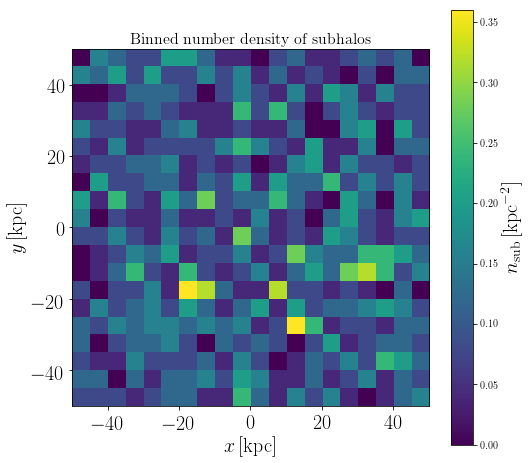

In [166]:
# Plot the binned map
map_index = 1
fig4, ax4 = plt.subplots(figsize=(8, 8))
im = ax4.imshow(nsubCDM0[map_index], origin='low', extent=[-pixmap.image_size/2,pixmap.image_size/2,-pixmap.image_size/2, pixmap.image_size/2])
ax4.set_xlabel(r'$x\,[{\rm kpc}]$', fontsize=20)
ax4.set_ylabel(r'$y\,[{\rm kpc}]$', fontsize=20)
ax4.set_title(r'Binned number density of subhalos',fontsize=16)
ticklabels = ax4.get_xticklabels()
ticklabels.extend(ax4.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
col = fig4.colorbar(im)
col.set_label(r'$n_{\rm sub}\,[{\rm kpc}^{-2}]$',fontsize=20)

Text(0.5,1,'Subhalo Convergence Map')

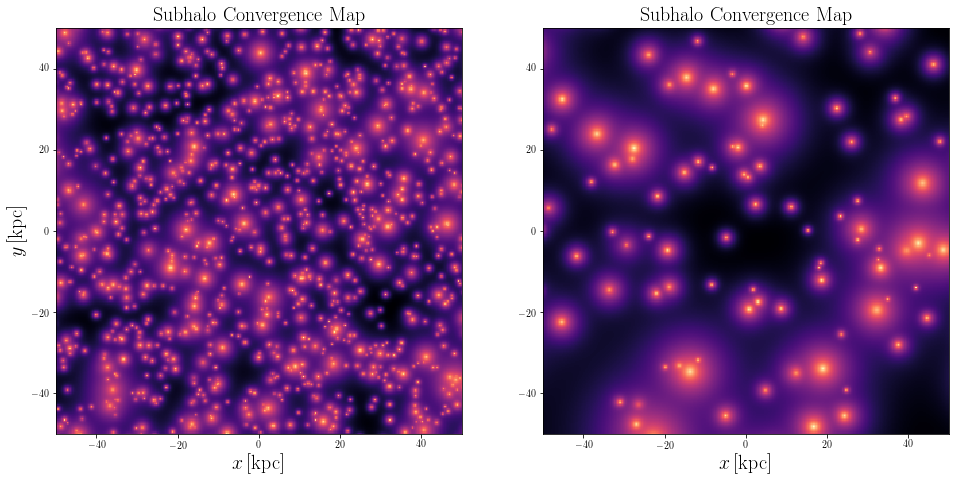

In [167]:
# Plot the map for visual inspection
maxx = pixmap.image_size/2
map_index = 0
fig4, (ax4, ax5) = plt.subplots(1,2,figsize=(16, 8))
ax4.imshow(np.log10(mapsCDM0[map_index]),cmap='magma',origin='lower',
                    extent=[-maxx, maxx, -maxx, maxx])
ax4.set_xlabel(r'$x\,[{\rm kpc}]$', fontsize=20)
ax4.set_ylabel(r'$y\,[{\rm kpc}]$', fontsize=20)
ax4.set_title(r'Subhalo Convergence Map', fontsize=20)

im = ax5.imshow(np.log10(mapsBurk0[map_index]),cmap='magma',origin='lower',
                    extent=[-maxx, maxx, -maxx, maxx])
ax5.set_xlabel(r'$x\,[{\rm kpc}]$', fontsize=20)
ax5.set_title(r'Subhalo Convergence Map', fontsize=20)

#col = fig4.colorbar(im)
#col.set_label(r'$\log_{10}(\kappa_{\rm sub})$',fontsize=16)

In [193]:
def plot_pksub_array(map1,map2,pixmap,num_k_bins,labels=[],meff=[1,1]):

    # Compute the power spectrum for each map
    kPk1 = [extract_pksub(map1[map_index],pixmap.image_size,num_k_bins) for map_index in range(map1.shape[0])]
    kPk2 = [extract_pksub(map2[map_index],pixmap.image_size,num_k_bins) for map_index in range(map2.shape[0])]

    #create figure
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(0.1,10)
   
    # plot
    for index in range(map1.shape[0]):
        if index == 0:
            labelh = labels[0]
        else:
            labelh = ''
        ax2.plot(kPk1[index][0], kPk1[index][1],c='k',label=labelh)
        ax2.plot(kPk1[index][0],np.mean(map1[index])*meff[0]*np.ones(kPk1[index][0].shape),c='k',ls='--',alpha=0.4)
    for index in range(map2.shape[0]):
        if index == 0:
            labelh = labels[1]
        else:
            labelh = ''
        ax2.plot(kPk2[index][0], kPk2[index][1],c='r',label=labelh)
        ax2.plot(kPk2[index][0],np.mean(map2[index])*meff[1]*np.ones(kPk2[index][0].shape),c='r',ls='--',alpha=0.4)

    ax2.set_xlabel(r'$k\,[{\rm kpc}^{-1}]$', fontsize=20)
    ax2.set_ylabel(r'$P_{\rm sub}(k)\,[{\rm kpc}^2]$', fontsize=20)

    ticklabels = ax2.get_xticklabels()
    ticklabels.extend(ax2.get_yticklabels())
    for label in ticklabels:
        label.set_color('k')
        label.set_fontsize(20)
    ax2.legend(fontsize=16)

In [190]:
meff_CDM05 = np.sum(m_CDM05**2)/m_CDM05.size/np.mean(m_CDM05)/(cosmo_lens1.sigma_crit/(cosmo_lens1.arcsec_2_kpc)**2)
meff_CDM0 = np.sum(m_CDM0**2)/m_CDM0.size/np.mean(m_CDM0)/(cosmo_lens1.sigma_crit/(cosmo_lens1.arcsec_2_kpc)**2)
meff_et05 = np.sum(m_et05**2)/m_et05.size/np.mean(m_et05)/(cosmo_lens1.sigma_crit/(cosmo_lens1.arcsec_2_kpc)**2)
meff_et0 = np.sum(m_et0**2)/m_et0.size/np.mean(m_et0)/(cosmo_lens1.sigma_crit/(cosmo_lens1.arcsec_2_kpc)**2)

In [126]:
print(np.mean(mapsCDM0)*meff_CDM0/(np.mean(mapsCDM05)*meff_CDM05))
print(np.mean(mapsBurk0)*meff_et0/(np.mean(mapsBurk05)*meff_et05))

1.54922694854
1.27113357956


In [200]:
np.sum(m_CDM05**2)/m_CDM05.size/np.mean(m_CDM05), np.sum(m_et05**2)/m_et05.size/np.mean(m_et05)

(26013168.482382618, 37542730.43597424)

/Users/Francis-yan/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Francis-yan/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


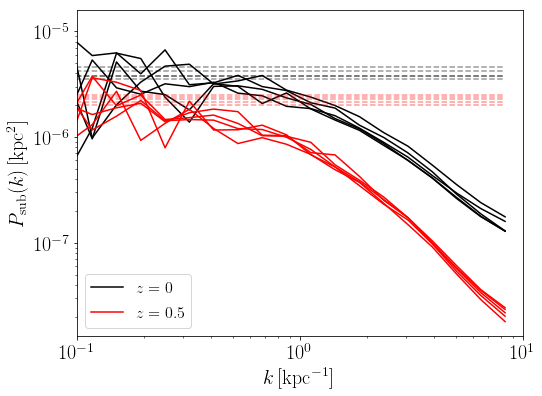

In [194]:
plot_pksub_array(mapsCDM0,mapsCDM05,pixmap,20,labels=[r'$z=0$',r'$z=0.5$'],meff=[meff_CDM0,meff_CDM05])

/Users/Francis-yan/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Francis-yan/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


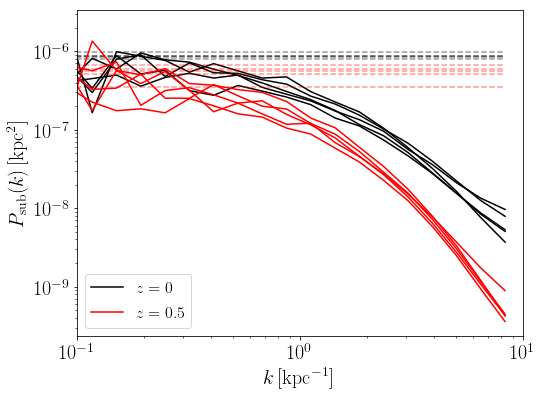

In [195]:
plot_pksub_array(mapsBurk0,mapsBurk05,pixmap,20,labels=[r'$z=0$',r'$z=0.5$'],meff=[meff_et0,meff_et05])

/Users/Francis-yan/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Francis-yan/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


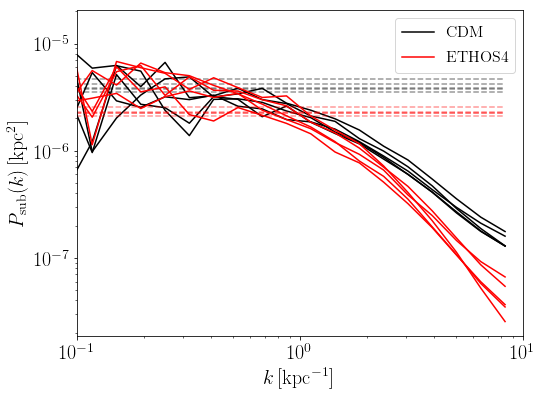

In [196]:
plot_pksub_array(mapsCDM0,4*(meff_CDM0/meff_et0)*mapsBurk0,pixmap,20,labels=[r'CDM',r'ETHOS4'],meff=[meff_CDM0,meff_et0])

# Look at the contribution from each subhalo mass bins

In [31]:
# Load properties
m6,pos6,rh6,rmax6 = read_catalogue(cat_list, mlow=m_res*37, mhigh=1e7)
m7,pos7,rh7,rmax7 = read_catalogue(cat_list, mlow=1e7, mhigh=1e8)
m8,pos8,rh8,rmax8 = read_catalogue(cat_list, mlow=1e8, mhigh=1e9)
m9,pos9,rh9,rmax9 = read_catalogue(cat_list, mlow=1e9, mhigh=1e10)

Processing file ../CDM/fof_subhalo_tab_095.0.hdf5
Processing file ../CDM/fof_subhalo_tab_095.2.hdf5
Processing file ../CDM/fof_subhalo_tab_095.3.hdf5
Processing file ../CDM/fof_subhalo_tab_095.4.hdf5
Processing file ../CDM/fof_subhalo_tab_095.5.hdf5
Processing file ../CDM/fof_subhalo_tab_095.6.hdf5
Processing file ../CDM/fof_subhalo_tab_095.7.hdf5
Processing file ../CDM/fof_subhalo_tab_095.8.hdf5
Processing file ../CDM/fof_subhalo_tab_095.9.hdf5
Processing file ../CDM/fof_subhalo_tab_095.10.hdf5
Processing file ../CDM/fof_subhalo_tab_095.11.hdf5
Processing file ../CDM/fof_subhalo_tab_095.12.hdf5
Processing file ../CDM/fof_subhalo_tab_095.13.hdf5
Processing file ../CDM/fof_subhalo_tab_095.14.hdf5
Processing file ../CDM/fof_subhalo_tab_095.15.hdf5
Processing file ../CDM/fof_subhalo_tab_095.0.hdf5
Processing file ../CDM/fof_subhalo_tab_095.2.hdf5
Processing file ../CDM/fof_subhalo_tab_095.3.hdf5
Processing file ../CDM/fof_subhalo_tab_095.4.hdf5
Processing file ../CDM/fof_subhalo_tab_095.5

In [32]:
# Compute NFW properties
r_s6, tau6, m_NFW6 = process_to_NFW(m6, rh6, rmax6)
r_s7, tau7, m_NFW7 = process_to_NFW(m7, rh7, rmax7)
r_s8, tau8, m_NFW8 = process_to_NFW(m8, rh8, rmax8)
r_s9, tau9, m_NFW9 = process_to_NFW(m9, rh9, rmax9)

In [33]:
# Generate some maps
pixmap = PixelMap(50,351)
seed = 97204
#maps = make_projected_maps(pos, m_NFW, r_s, tau, cosmo_lens, pixmap, num_maps=3, keep_fac=2, seed=seed)
map6 = make_projected_maps(pos6, m_NFW6, r_s6, tau6, cosmo_lens, pixmap, num_maps=10, keep_fac=2, seed=seed)
map7 = make_projected_maps(pos7, m_NFW7, r_s7, tau7, cosmo_lens, pixmap, num_maps=10, keep_fac=2, seed=seed)
map8 = make_projected_maps(pos8, m_NFW8, r_s8, tau8, cosmo_lens, pixmap, num_maps=10, keep_fac=2, seed=seed)
map9 = make_projected_maps(pos9, m_NFW9, r_s9, tau9, cosmo_lens, pixmap, num_maps=10, keep_fac=2, seed=seed)

Processing Map 1 out of 10
Processing Map 2 out of 10
Processing Map 3 out of 10
Processing Map 4 out of 10
Processing Map 5 out of 10
Processing Map 6 out of 10
Processing Map 7 out of 10
Processing Map 8 out of 10
Processing Map 9 out of 10
Processing Map 10 out of 10
Processing Map 1 out of 10
Processing Map 2 out of 10
Processing Map 3 out of 10
Processing Map 4 out of 10
Processing Map 5 out of 10
Processing Map 6 out of 10
Processing Map 7 out of 10
Processing Map 8 out of 10
Processing Map 9 out of 10
Processing Map 10 out of 10
Processing Map 1 out of 10
Processing Map 2 out of 10
Processing Map 3 out of 10
Processing Map 4 out of 10
Processing Map 5 out of 10
Processing Map 6 out of 10
Processing Map 7 out of 10
Processing Map 8 out of 10
Processing Map 9 out of 10
Processing Map 10 out of 10
Processing Map 1 out of 10
Processing Map 2 out of 10
Processing Map 3 out of 10
Processing Map 4 out of 10
Processing Map 5 out of 10
Processing Map 6 out of 10
Processing Map 7 out of 1

Text(0.5,1,'Subhalo Convergence Map: Sum of mass bins')

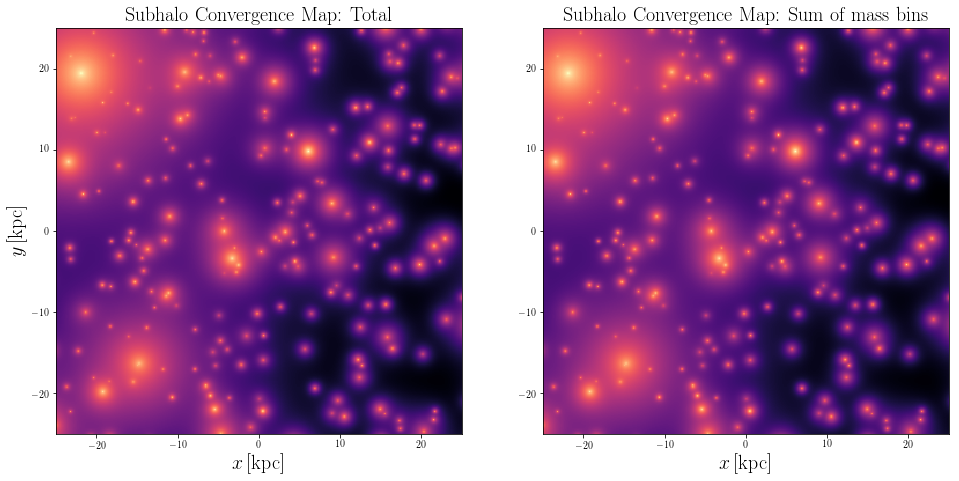

In [34]:
# Plot the map for visual inspection
maxx = pixmap.image_size/2
map_index = 0
fig4, (ax4, ax5) = plt.subplots(1,2,figsize=(16, 8))
ax4.imshow(np.log10(maps[map_index]),cmap='magma',origin='lower',
                    extent=[-maxx, maxx, -maxx, maxx])
ax4.set_xlabel(r'$x\,[{\rm kpc}]$', fontsize=20)
ax4.set_ylabel(r'$y\,[{\rm kpc}]$', fontsize=20)
ax4.set_title(r'Subhalo Convergence Map: Total', fontsize=20)

im = ax5.imshow(np.log10(map6[map_index] + map7[map_index] + map8[map_index] + map9[map_index]),cmap='magma',origin='lower',
                    extent=[-maxx, maxx, -maxx, maxx])
ax5.set_xlabel(r'$x\,[{\rm kpc}]$', fontsize=20)
ax5.set_title(r'Subhalo Convergence Map: Sum of mass bins', fontsize=20)

#col = fig4.colorbar(im)
#col.set_label(r'$\log_{10}(\kappa_{\rm sub})$',fontsize=16)

In [36]:
# Check that they are the same maps
[np.min(map6[map_index] + map7[map_index] + map8[map_index] + map9[map_index] - maps[map_index]) for map_index in range(10)]

[-1.3877787807814457e-16,
 -9.0205620750793969e-17,
 -1.2490009027033011e-16,
 -1.8041124150158794e-16,
 -7.6327832942979512e-17,
 -2.0816681711721685e-16,
 -7.2858385991025898e-17,
 -9.0205620750793969e-17,
 -1.457167719820518e-16,
 -1.1796119636642288e-16]

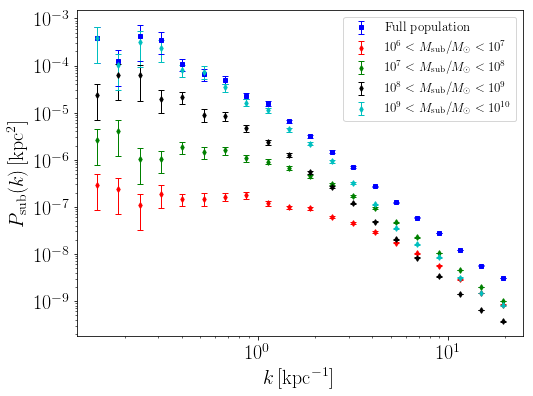

In [139]:
map_index = 1
log_binh = True
kvec, Psub, ePsub = extract_pksub(maps[map_index],pixmap.image_size,20,log_bin=log_binh)
kvec6, Psub6, ePsub6 = extract_pksub(map6[map_index],pixmap.image_size,20,log_bin=log_binh)
kvec7, Psub7, ePsub7 = extract_pksub(map7[map_index],pixmap.image_size,20,log_bin=log_binh)
kvec8, Psub8, ePsub8 = extract_pksub(map8[map_index],pixmap.image_size,20,log_bin=log_binh)
kvec9, Psub9, ePsub9 = extract_pksub(map9[map_index],pixmap.image_size,20,log_bin=log_binh)

fig2, ax2 = plt.subplots(figsize=(8, 6))
if log_binh:
    ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.set_ylim(1e-11,1e-4)

ax2.errorbar(kvec, Psub,yerr= ePsub, fmt='sb', ms=4, capsize=3,elinewidth=1,label=r'Full population')
#ax2.errorbar(kvec, Psub6 + Psub7 + Psub8 + Psub9 ,yerr= ePsub, fmt='^m', ms=4, capsize=3,elinewidth=1,label=r'Sum')
ax2.errorbar(kvec6, Psub6,yerr= ePsub6, fmt='dr', ms=4, capsize=3,elinewidth=1,label=r'$10^6<M_{\rm sub}/M_\odot< 10^7$')
ax2.errorbar(kvec7, Psub7,yerr= ePsub7, fmt='dg', ms=4, capsize=3,elinewidth=1,label=r'$10^7<M_{\rm sub}/M_\odot< 10^8$')
ax2.errorbar(kvec8, Psub8,yerr= ePsub8, fmt='dk', ms=4, capsize=3,elinewidth=1,label=r'$10^8<M_{\rm sub}/M_\odot< 10^9$')
ax2.errorbar(kvec9, Psub9,yerr= ePsub9, fmt='dc', ms=4, capsize=3,elinewidth=1,label=r'$10^9<M_{\rm sub}/M_\odot< 10^{10}$')

ax2.set_xlabel(r'$k\,[{\rm kpc}^{-1}]$', fontsize=20)
ax2.set_ylabel(r'$P_{\rm sub}(k)\,[{\rm kpc}^2]$', fontsize=20)

ticklabels = ax2.get_xticklabels()
ticklabels.extend(ax2.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
ax2.legend(fontsize=13)

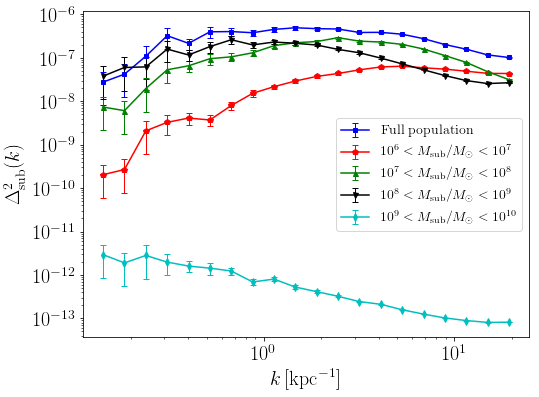

In [152]:
map_index = 3
log_binh = True
N_bins = 20
kvec, Psub, ePsub = extract_pksub(maps[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec6, Psub6, ePsub6 = extract_pksub(map6[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec7, Psub7, ePsub7 = extract_pksub(map7[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec8, Psub8, ePsub8 = extract_pksub(map8[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec9, Psub9, ePsub9 = extract_pksub(map9[map_index],pixmap.image_size,N_bins,log_bin=log_binh)

fig2, ax2 = plt.subplots(figsize=(8, 6))
if log_binh:
    ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.set_ylim(1e-11,1e-4)


#ax2.errorbar(kvec, kvec**2*Psub/(2*np.pi),yerr= kvec**2*ePsub/(2*np.pi), fmt='sb', ms=4, capsize=3,elinewidth=1,label=r'Full population')
#ax2.errorbar(kvec, kvec**2*(Psub6 + Psub7 + Psub8 + Psub9)/(2*np.pi) ,yerr= kvec**2*ePsub/(2*np.pi), fmt='^m', ms=4, capsize=3,elinewidth=1,label=r'Sum')
#ax2.errorbar(kvec6, kvec6**2*Psub6/(2*np.pi),yerr= kvec**2*ePsub6/(2*np.pi), fmt='dr', ms=4, capsize=3,elinewidth=1,label=r'$10^6<M_{\rm sub}/M_\odot< 10^7$')
#ax2.errorbar(kvec7, kvec7**2*Psub7/(2*np.pi),yerr= kvec**2*ePsub7/(2*np.pi), fmt='dg', ms=4, capsize=3,elinewidth=1,label=r'$10^7<M_{\rm sub}/M_\odot< 10^8$')
#ax2.errorbar(kvec8, kvec8**2*Psub8/(2*np.pi),yerr= kvec**2*ePsub8/(2*np.pi), fmt='dk', ms=4, capsize=3,elinewidth=1,label=r'$10^8<M_{\rm sub}/M_\odot< 10^9$')
#ax2.errorbar(kvec9, kvec9**2*Psub9/(2*np.pi),yerr= kvec**2*ePsub9/(2*np.pi), fmt='dc', ms=4, capsize=3,elinewidth=1,label=r'$10^9<M_{\rm sub}/M_\odot< 10^{10}$')

ax2.errorbar(kvec, kvec**2*Psub/(2*np.pi),yerr= kvec**2*ePsub/(2*np.pi), marker='s',c='b', ms=4, capsize=3,elinewidth=1,label=r'Full population')
#ax2.errorbar(kvec, kvec**2*(Psub6 + Psub7 + Psub8 + Psub9)/(2*np.pi) ,yerr= kvec**2*ePsub/(2*np.pi), fmt='^m', ms=4, capsize=3,elinewidth=1,label=r'Sum')
ax2.errorbar(kvec6, kvec6**2*Psub6/(2*np.pi),yerr= kvec**2*ePsub6/(2*np.pi), marker='p',c='r', ms=6, capsize=3,elinewidth=1,label=r'$10^6<M_{\rm sub}/M_\odot< 10^7$')
ax2.errorbar(kvec7, kvec7**2*Psub7/(2*np.pi),yerr= kvec**2*ePsub7/(2*np.pi), marker='^', c='g', ms=5, capsize=3,elinewidth=1,label=r'$10^7<M_{\rm sub}/M_\odot< 10^8$')
ax2.errorbar(kvec8, kvec8**2*Psub8/(2*np.pi),yerr= kvec**2*ePsub8/(2*np.pi), marker='v',c='k', ms=5, capsize=3,elinewidth=1,label=r'$10^8<M_{\rm sub}/M_\odot< 10^9$')
ax2.errorbar(kvec9, kvec9**2*Psub9/(2*np.pi),yerr= kvec**2*ePsub9/(2*np.pi), marker='d',c='c', ms=5, capsize=3,elinewidth=1,label=r'$10^9<M_{\rm sub}/M_\odot< 10^{10}$')


ax2.set_xlabel(r'$k\,[{\rm kpc}^{-1}]$', fontsize=20)
ax2.set_ylabel(r'$\Delta^2_{\rm sub}(k)$', fontsize=20)

ticklabels = ax2.get_xticklabels()
ticklabels.extend(ax2.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
ax2.legend(fontsize=14)

fig2.savefig('plots/Power_spec_mass_comp_log_'+ str(seed)+'_'+str(map_index)+'.pdf',bbox_inches='tight')

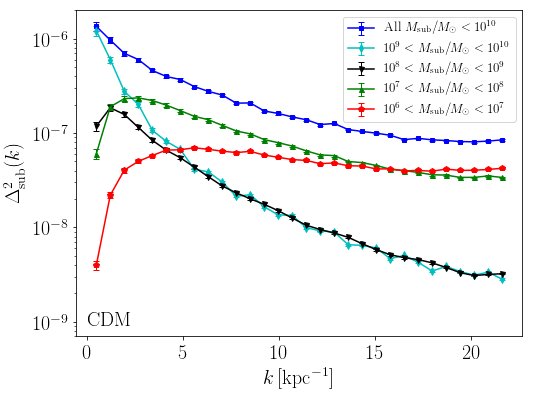

In [161]:
map_index = 0
log_binh = False
N_bins = 30
kvec, Psub, ePsub = extract_pksub(maps[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec6, Psub6, ePsub6 = extract_pksub(map6[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec7, Psub7, ePsub7 = extract_pksub(map7[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec8, Psub8, ePsub8 = extract_pksub(map8[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec9, Psub9, ePsub9 = extract_pksub(map9[map_index],pixmap.image_size,N_bins,log_bin=log_binh)

fig2, ax2 = plt.subplots(figsize=(8, 6))
if log_binh:
    ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(7e-10,2e-6)


ax2.errorbar(kvec, kvec**2*Psub/(2*np.pi),yerr= kvec**2*ePsub/(2*np.pi), marker='s',c='b', ms=4, capsize=3,elinewidth=1,label=r'All $M_{\rm sub}/M_\odot< 10^{10}$')
#ax2.errorbar(kvec, kvec**2*(Psub6 + Psub7 + Psub8 + Psub9)/(2*np.pi) ,yerr= kvec**2*ePsub/(2*np.pi), fmt='^m', ms=4, capsize=3,elinewidth=1,label=r'Sum')
ax2.errorbar(kvec9, kvec9**2*Psub9/(2*np.pi),yerr= kvec**2*ePsub9/(2*np.pi), marker='d',c='c', ms=5, capsize=3,elinewidth=1,label=r'$10^9<M_{\rm sub}/M_\odot< 10^{10}$')
ax2.errorbar(kvec8, kvec8**2*Psub8/(2*np.pi),yerr= kvec**2*ePsub8/(2*np.pi), marker='v',c='k', ms=5, capsize=3,elinewidth=1,label=r'$10^8<M_{\rm sub}/M_\odot< 10^9$')
ax2.errorbar(kvec7, kvec7**2*Psub7/(2*np.pi),yerr= kvec**2*ePsub7/(2*np.pi), marker='^', c='g', ms=5, capsize=3,elinewidth=1,label=r'$10^7<M_{\rm sub}/M_\odot< 10^8$')
ax2.errorbar(kvec6, kvec6**2*Psub6/(2*np.pi),yerr= kvec**2*ePsub6/(2*np.pi), marker='p',c='r', ms=6, capsize=3,elinewidth=1,label=r'$10^6<M_{\rm sub}/M_\odot< 10^7$')




ax2.set_xlabel(r'$k\,[{\rm kpc}^{-1}]$', fontsize=20)
ax2.set_ylabel(r'$\Delta^2_{\rm sub}(k)$', fontsize=20)

ticklabels = ax2.get_xticklabels()
ticklabels.extend(ax2.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
ax2.legend(fontsize=13)

ax2.text(0,0.9e-9,'CDM',fontsize=20)

fig2.savefig('plots/Power_spec_mass_comp_cdm_z_05_'+ str(seed)+'_'+str(map_index)+'.png',bbox_inches='tight',dpi=300)



# Now redo the mass separation for the ETHOS-4 case

In [285]:
# Load properties
m6,pos6,rh6,rmax6 = read_catalogue(cat_list_ethos, mlow=m_res*37, mhigh=1e7)
m7,pos7,rh7,rmax7 = read_catalogue(cat_list_ethos, mlow=1e7, mhigh=1e8)
m8,pos8,rh8,rmax8 = read_catalogue(cat_list_ethos, mlow=1e8, mhigh=1e9)
m9,pos9,rh9,rmax9 = read_catalogue(cat_list_ethos, mlow=1e9, mhigh=1e10)
mall,posall,rhall,rmaxall =  read_catalogue(cat_list_ethos, mlow=m_res*37, mhigh=1e10)

Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.0.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.2.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.3.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.4.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.5.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.6.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.7.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.8.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.9.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.10.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.11.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.12.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.13.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.14.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.15.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.0.hdf5
Processing file ../ETHOS_4_cat/fof_subhalo_tab_095.2.hdf5
Processi

In [286]:
# Compute Burkert properties 
r_b6, taub6, m_b6 = process_to_Burk(m6, rh6, rmax6)
r_b7, taub7, m_b7 = process_to_Burk(m7, rh7, rmax7)
r_b8, taub8, m_b8 = process_to_Burk(m8, rh8, rmax8)
r_b9, taub9, m_b9 = process_to_Burk(m9, rh9, rmax9)
r_ball, tauball, m_ball = process_to_Burk(mall, rhall, rmaxall)

In [287]:
# Generate some maps
pixmap = PixelMap(50,351)
seed = 97204
mapsall = make_projected_maps_burk(posall, m_ball, r_ball, tauball, cosmo_lens, pixmap, num_maps=10, keep_fac=2, seed=seed)
map6 = make_projected_maps_burk(pos6, m_b6, r_b6, taub6, cosmo_lens, pixmap, num_maps=10, keep_fac=2, seed=seed)
map7 = make_projected_maps_burk(pos7, m_b7, r_b7, taub7, cosmo_lens, pixmap, num_maps=10, keep_fac=2, seed=seed)
map8 = make_projected_maps_burk(pos8, m_b8, r_b8, taub8, cosmo_lens, pixmap, num_maps=10, keep_fac=2, seed=seed)
map9 = make_projected_maps_burk(pos9, m_b9, r_b9, taub9, cosmo_lens, pixmap, num_maps=10, keep_fac=2, seed=seed)

Processing Map 1 out of 10
Processing Map 2 out of 10
Processing Map 3 out of 10
Processing Map 4 out of 10
Processing Map 5 out of 10
Processing Map 6 out of 10
Processing Map 7 out of 10
Processing Map 8 out of 10
Processing Map 9 out of 10
Processing Map 10 out of 10
Processing Map 1 out of 10
Processing Map 2 out of 10
Processing Map 3 out of 10
Processing Map 4 out of 10
Processing Map 5 out of 10
Processing Map 6 out of 10
Processing Map 7 out of 10
Processing Map 8 out of 10
Processing Map 9 out of 10
Processing Map 10 out of 10
Processing Map 1 out of 10
Processing Map 2 out of 10
Processing Map 3 out of 10
Processing Map 4 out of 10
Processing Map 5 out of 10
Processing Map 6 out of 10
Processing Map 7 out of 10
Processing Map 8 out of 10
Processing Map 9 out of 10
Processing Map 10 out of 10
Processing Map 1 out of 10
Processing Map 2 out of 10
Processing Map 3 out of 10
Processing Map 4 out of 10
Processing Map 5 out of 10
Processing Map 6 out of 10
Processing Map 7 out of 1

Text(0.5,1,'Subhalo Convergence Map: Sum of mass bins')

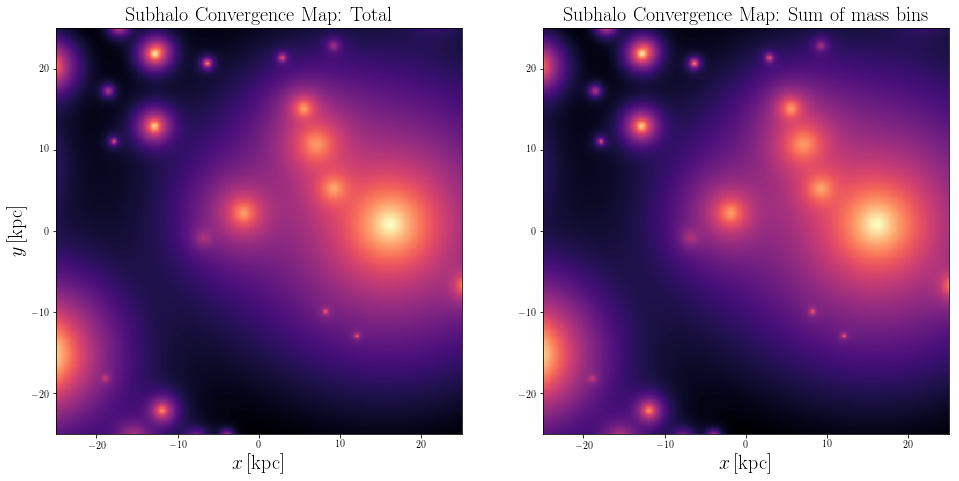

In [319]:
# Plot the map for visual inspection
maxx = pixmap.image_size/2
map_index = 2
fig4, (ax4, ax5) = plt.subplots(1,2,figsize=(16, 8))
ax4.imshow(np.log10(mapsall[map_index]),cmap='magma',origin='lower',
                    extent=[-maxx, maxx, -maxx, maxx])
ax4.set_xlabel(r'$x\,[{\rm kpc}]$', fontsize=20)
ax4.set_ylabel(r'$y\,[{\rm kpc}]$', fontsize=20)
ax4.set_title(r'Subhalo Convergence Map: Total', fontsize=20)

im = ax5.imshow(np.log10(map6[map_index] + map7[map_index] + map8[map_index] + map9[map_index]),cmap='magma',origin='lower',
                    extent=[-maxx, maxx, -maxx, maxx])
ax5.set_xlabel(r'$x\,[{\rm kpc}]$', fontsize=20)
ax5.set_title(r'Subhalo Convergence Map: Sum of mass bins', fontsize=20)

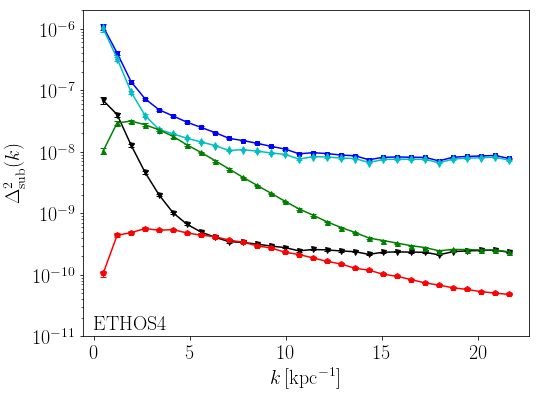

In [356]:
map_index = 2
log_binh = False
N_bins = 30
kvec, Psub, ePsub = extract_pksub(mapsall[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec6, Psub6, ePsub6 = extract_pksub(map6[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec7, Psub7, ePsub7 = extract_pksub(map7[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec8, Psub8, ePsub8 = extract_pksub(map8[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec9, Psub9, ePsub9 = extract_pksub(map9[map_index],pixmap.image_size,N_bins,log_bin=log_binh)

fig2, ax2 = plt.subplots(figsize=(8, 6))
if log_binh:
    ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(1e-11,2e-6)


ax2.errorbar(kvec, kvec**2*Psub/(2*np.pi),yerr= kvec**2*ePsub/(2*np.pi), marker='s',c='b', ms=4, capsize=3,elinewidth=1,label=r'All $M_{\rm sub}/M_\odot< 10^{10}$')
#ax2.errorbar(kvec, kvec**2*(Psub6 + Psub7 + Psub8 + Psub9)/(2*np.pi) ,yerr= kvec**2*ePsub/(2*np.pi), fmt='^m', ms=4, capsize=3,elinewidth=1,label=r'Sum')
ax2.errorbar(kvec9, kvec9**2*Psub9/(2*np.pi),yerr= kvec**2*ePsub9/(2*np.pi), marker='d',c='c', ms=5, capsize=3,elinewidth=1,label=r'$10^9<M_{\rm sub}/M_\odot< 10^{10}$')
ax2.errorbar(kvec8, kvec8**2*Psub8/(2*np.pi),yerr= kvec**2*ePsub8/(2*np.pi), marker='v',c='k', ms=5, capsize=3,elinewidth=1,label=r'$10^8<M_{\rm sub}/M_\odot< 10^9$')
ax2.errorbar(kvec7, kvec7**2*Psub7/(2*np.pi),yerr= kvec**2*ePsub7/(2*np.pi), marker='^', c='g', ms=5, capsize=3,elinewidth=1,label=r'$10^7<M_{\rm sub}/M_\odot< 10^8$')
ax2.errorbar(kvec6, kvec6**2*Psub6/(2*np.pi),yerr= kvec**2*ePsub6/(2*np.pi), marker='p',c='r', ms=6, capsize=3,elinewidth=1,label=r'$10^6<M_{\rm sub}/M_\odot< 10^7$')




ax2.set_xlabel(r'$k\,[{\rm kpc}^{-1}]$', fontsize=20)
ax2.set_ylabel(r'$\Delta^2_{\rm sub}(k)$', fontsize=20)

ticklabels = ax2.get_xticklabels()
ticklabels.extend(ax2.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
#ax2.legend(fontsize=14)

ax2.text(0,1.3e-11,'ETHOS4',fontsize=20)

fig2.savefig('plots/Power_spec_mass_comp_ethos4_z_05_'+ str(seed)+'_'+str(map_index)+'.png',bbox_inches='tight',dpi=300)


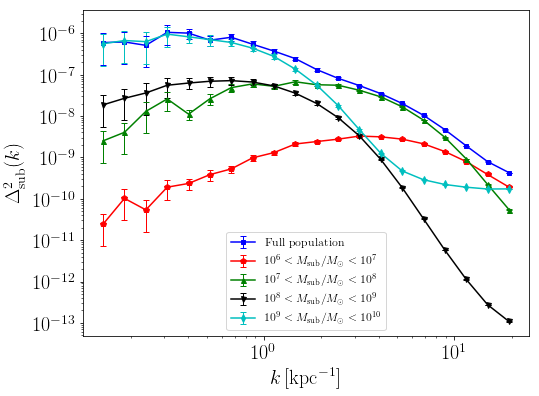

In [316]:
map_index = 0
log_binh = True
N_bins = 20
kvec, Psub, ePsub = extract_pksub(mapsall[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec6, Psub6, ePsub6 = extract_pksub(map6[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec7, Psub7, ePsub7 = extract_pksub(map7[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec8, Psub8, ePsub8 = extract_pksub(map8[map_index],pixmap.image_size,N_bins,log_bin=log_binh)
kvec9, Psub9, ePsub9 = extract_pksub(map9[map_index],pixmap.image_size,N_bins,log_bin=log_binh)

fig2, ax2 = plt.subplots(figsize=(8, 6))
if log_binh:
    ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.set_ylim(1e-11,1e-4)


#ax2.errorbar(kvec, kvec**2*Psub/(2*np.pi),yerr= kvec**2*ePsub/(2*np.pi), fmt='sb', ms=4, capsize=3,elinewidth=1,label=r'Full population')
#ax2.errorbar(kvec, kvec**2*(Psub6 + Psub7 + Psub8 + Psub9)/(2*np.pi) ,yerr= kvec**2*ePsub/(2*np.pi), fmt='^m', ms=4, capsize=3,elinewidth=1,label=r'Sum')
#ax2.errorbar(kvec6, kvec6**2*Psub6/(2*np.pi),yerr= kvec**2*ePsub6/(2*np.pi), fmt='dr', ms=4, capsize=3,elinewidth=1,label=r'$10^6<M_{\rm sub}/M_\odot< 10^7$')
#ax2.errorbar(kvec7, kvec7**2*Psub7/(2*np.pi),yerr= kvec**2*ePsub7/(2*np.pi), fmt='dg', ms=4, capsize=3,elinewidth=1,label=r'$10^7<M_{\rm sub}/M_\odot< 10^8$')
#ax2.errorbar(kvec8, kvec8**2*Psub8/(2*np.pi),yerr= kvec**2*ePsub8/(2*np.pi), fmt='dk', ms=4, capsize=3,elinewidth=1,label=r'$10^8<M_{\rm sub}/M_\odot< 10^9$')
#ax2.errorbar(kvec9, kvec9**2*Psub9/(2*np.pi),yerr= kvec**2*ePsub9/(2*np.pi), fmt='dc', ms=4, capsize=3,elinewidth=1,label=r'$10^9<M_{\rm sub}/M_\odot< 10^{10}$')

ax2.errorbar(kvec, kvec**2*Psub/(2*np.pi),yerr= kvec**2*ePsub/(2*np.pi), marker='s',c='b', ms=4, capsize=3,elinewidth=1,label=r'Full population')
#ax2.errorbar(kvec, kvec**2*(Psub6 + Psub7 + Psub8 + Psub9)/(2*np.pi) ,yerr= kvec**2*ePsub/(2*np.pi), fmt='^m', ms=4, capsize=3,elinewidth=1,label=r'Sum')
ax2.errorbar(kvec6, kvec6**2*Psub6/(2*np.pi),yerr= kvec**2*ePsub6/(2*np.pi), marker='p',c='r', ms=6, capsize=3,elinewidth=1,label=r'$10^6<M_{\rm sub}/M_\odot< 10^7$')
ax2.errorbar(kvec7, kvec7**2*Psub7/(2*np.pi),yerr= kvec**2*ePsub7/(2*np.pi), marker='^', c='g', ms=5, capsize=3,elinewidth=1,label=r'$10^7<M_{\rm sub}/M_\odot< 10^8$')
ax2.errorbar(kvec8, kvec8**2*Psub8/(2*np.pi),yerr= kvec**2*ePsub8/(2*np.pi), marker='v',c='k', ms=5, capsize=3,elinewidth=1,label=r'$10^8<M_{\rm sub}/M_\odot< 10^9$')
ax2.errorbar(kvec9, kvec9**2*Psub9/(2*np.pi),yerr= kvec**2*ePsub9/(2*np.pi), marker='d',c='c', ms=5, capsize=3,elinewidth=1,label=r'$10^9<M_{\rm sub}/M_\odot< 10^{10}$')


ax2.set_xlabel(r'$k\,[{\rm kpc}^{-1}]$', fontsize=20)
ax2.set_ylabel(r'$\Delta^2_{\rm sub}(k)$', fontsize=20)

ticklabels = ax2.get_xticklabels()
ticklabels.extend(ax2.get_yticklabels())
for label in ticklabels:
    label.set_color('k')
    label.set_fontsize(20)
ax2.legend(fontsize=12)